# Feature comparisons between allowing and excluding paths with duplicate nodes

In [1]:
import re
import functools

import pandas
import matplotlib.pyplot
import seaborn
import numpy
import sklearn.metrics
import qgrid

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
seaborn.set_style('whitegrid')
%matplotlib inline

In [3]:
# Read feature and partition data
feature_df = pandas.read_table('features.tsv.gz', nrows=None)
part_df = pandas.read_table('../data/partition.tsv.gz')

In [4]:
@functools.lru_cache(maxsize=None)
def duplicate_metanodes(metapath):
    metanodes = re.split('[a-z<>]+', metapath)
    return len(set(metanodes)) < len(metanodes)

# Restrict to metapaths that have duplicate metanodes
feature_df = feature_df[feature_df.metapath.map(duplicate_metanodes)]

In [5]:
dfs = {}
for key in 'PC', 'DWPC':
    # Create spread dataframe
    df = feature_df.pivot_table(values=key, index=['compound_id', 'disease_id', 'metapath'], columns='unique_nodes')
    df = df.dropna() # use if only reading a part of `dwpc.tsv.gz`
    
    # Check that the two methods of duplicate node exclusion produce the same results
    assert all(numpy.isclose(df.nested, df.expanded) & numpy.isclose(df.expanded, df.labeled))
    
    # Remove duplicate columns and rename columns
    df = df.drop(['nested', 'expanded'], axis=1)
    df = df.rename(columns={'False': key + '_dupl', 'labeled': key + '_nodupl'})
    dfs[key] = df

# Create a spread dataframe of Path Counts
spread_df = pandas.concat(dfs.values(), axis=1).reset_index()

In [6]:
spread_df.head(2)

unique_nodes,compound_id,disease_id,metapath,DWPC_dupl,DWPC_nodupl,PC_dupl,PC_nodupl
0,DB00091,DOID:1312,CbG<kdG<kdGaD,0.000601,0.000601,18,18
1,DB00091,DOID:1312,CbG<kdG<kdGdD,0.000000,0.000000,0,0


# PC differences

In [7]:
# Filter for differing rows
pct_disagree = 100 * (spread_df['PC_nodupl'] != spread_df['PC_dupl']).mean()
'{:.02f}% of path counts were affected by the unique node constraint'.format(pct_disagree)

'2.79% of path counts were affected by the unique node constraint'

In [8]:
def metapath_summarize(df):
    """
    Summarize a feature dataframe for a single metapath.
    """
    row = pandas.Series()
    
    # Find instances were path counts are affected by duplicate node exlusion
    disagree = df['PC_nodupl'] != df['PC_dupl']
    
    # Percent of compound-disease pairs (instances) that the unique node constraint has an effect
    row['pct_affected'] = 100 * sum(disagree) / len(df)
    
    # Compare average path counts when allowing and excluding duplicate nodes
    row['mean_PC_dupl'] = df['PC_dupl'].mean()
    row['mean_PC_nodupl'] = df['PC_nodupl'].mean()
    row['mean_pct_PC_increase'] = 100 * row['mean_PC_dupl'] / row['mean_PC_nodupl'] - 100
    
    # Calculate PC increases caused by allowing duplicate nodes seperately for indications and non-indications
    neg_df = df[df.indication == 0]
    pos_df = df[df.indication == 1]
    row['mean_pct_PC_increase_nonind'] = 100 * neg_df['PC_dupl'].mean() / neg_df['PC_nodupl'].mean() - 100
    row['mean_pct_PC_increase_ind'] = 100 * pos_df['PC_dupl'].mean() / pos_df['PC_nodupl'].mean() - 100
    
    # Calculate AUROCs of DWPCs when allowing and excluding duplicate nodes
    row['auroc_dupl'] = sklearn.metrics.roc_auc_score(df['indication'], df['DWPC_dupl'])
    row['auroc_nodupl'] = sklearn.metrics.roc_auc_score(df['indication'], df['DWPC_nodupl'])
    row['auroc_diff'] = row['auroc_dupl'] - row['auroc_nodupl']
    
    return row

In [9]:
# Summarize features by metapath
merged_df = part_df.merge(spread_df)
metapath_df = merged_df.groupby('metapath').apply(metapath_summarize).fillna(0)
metapath_df = metapath_df.sort_values('pct_affected', ascending=False)
metapath_df['indication_metaedge'] = metapath_df.index.str.contains(r'CiD|DiC')
metapath_df.reset_index().to_csv('metapaths.tsv', sep='\t', index=False, float_format='%.3g')
len(metapath_df)

1961

In [10]:
grid_options = {
    'forceFitColumns': False,
    'defaultColumnWidth': 200,
    'editable': False,
    'syncColumnCellResize': True,
    'rowHeight': 28,
}
qgrid.show_grid(metapath_df, grid_options=grid_options, precision=2, remote_js=True)

In [11]:
'{:.02f}% of metapaths had diminished AUROCs when exlcuding duplicate nodes.'.format(100 * (metapath_df.auroc_diff > 0).mean())

'21.62% of metapaths had diminished AUROCs when exlcuding duplicate nodes.'

In [12]:
pct_suffer = metapath_df.query('auroc_diff > 0.005').indication_metaedge.mean() * 100
'{:.02f}% of AUROC-suffering (> 0.005) metapaths contained an indication metaedge.'.format(pct_suffer)

'100.00% of AUROC-suffering (> 0.005) metapaths contained an indication metaedge.'

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


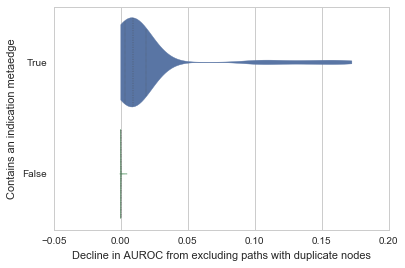

In [13]:
# Plot distributions of decline in metapath AUROC from excluding duplicate-node paths
ax = seaborn.violinplot('auroc_diff', 'indication_metaedge', data=metapath_df, orient='h',
                        scale='width', cut=0, inner='quartile', linewidth=0.4)
matplotlib.pyplot.xlabel('Decline in AUROC from excluding paths with duplicate nodes');
matplotlib.pyplot.ylabel('Contains an indication metaedge');
matplotlib.pyplot.savefig('AUROC-violins.png', dpi=200, bbox_inches='tight', pad_inches=0.03)